In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
# from utils.model_utils import wmape
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv(f"C:/Users/Mihir/vscode_workspace/WAT.ai/20220101_pv_joined.csv", index_col=0)
df.dropna(subset=['instantaneous_power_W', 'latitude', 'longitude', 'cdir'], axis=0, inplace=True)
for i in range(2,21):
    a = i if len(str(i)) > 1 else '0' + str(i)
    day_df = pd.read_csv(f"C:/Users/Mihir/vscode_workspace/WAT.ai/202201{a}_pv_joined.csv", index_col=0)
    day_df.dropna(subset=['instantaneous_power_W', 'latitude', 'longitude', 'cdir'], axis=0, inplace=True)
    df = pd.concat([df, day_df], axis=0, ignore_index=True)

In [3]:
df.wind.unique()

array([nan])

In [4]:
df.drop(['temperature_C', 'voltage', 'dwi', 'wind'], axis=1, inplace=True)

In [5]:
#sns.heatmap(df.drop(['time', 'instantaneous_power_W'], axis=1).corrwith(df['instantaneous_power_W']))

In [6]:
df.head()

,system_id,time,instantaneous_power_W,latitude,longitude,alnid,alnip,aluvd,aluvp,bld,...,tsr,tsrc,ttr,ttrc,u10,u100,u10n,uvb,v10,v100
0,8328,2022-01-01 06:00:00,0.0,41.00,14.25,0.136493,0.128418,0.055422,0.053528,2115.0000,...,0.00,0.00,-944726.60,-935018.56,0.030451,0.255241,0.211633,0.0000,0.321944,0.933605
1,30312,2022-01-01 06:00:00,2.0,37.50,15.00,0.186403,0.179201,0.046982,0.045113,1536.0000,...,0.00,0.00,-925133.20,-923962.50,1.382719,1.857453,1.152041,0.0000,-1.795812,-2.387222
2,29989,2022-01-01 07:00:00,18.0,40.00,18.25,0.122121,0.114193,0.053834,0.052220,6974.5000,...,178847.25,175495.25,-954412.50,-956691.80,1.703351,2.414794,1.685663,11238.1250,-3.481762,-6.293553
3,71633,2022-01-01 07:00:00,159.0,37.75,14.75,0.207172,0.193765,0.053990,0.052348,9828.1875,...,127114.50,127606.50,-924962.70,-938612.50,0.079361,1.194824,0.078454,8186.6094,-2.197811,-3.964417
4,8328,2022-01-01 07:00:00,0.0,41.00,14.25,0.136493,0.128418,0.055408,0.053528,1598.0625,...,53728.00,57379.00,-955964.25,-942700.25,0.277718,0.653505,0.466213,2493.7188,0.325001,0.756270


# Identifying Categorical Data
If we join metadata to the nwp, then we woudl also have categorical features such as panel_brand, orientation, and shade.

In [7]:
categorical_names = ['system_id', 'ptype']
categorical_locs = [df.columns.get_loc(name) for name in categorical_names]

for feature in categorical_names:
 df[feature] = pd.Series(df[feature], dtype="category")

# Specify Model Params

In [8]:
lgbm_params = {
 'subsample_freq': 1,
 'subsample': 1,
 'num_leaves': 30,
 'n_estimators': 1000,
 'min_split_gain': 0.0001,
 'min_child_weight': 0,
 'min_child_samples': 20,
 'max_depth': 10,
 'learning_rate': 0.04,
 'colsample_bytree': 0.5,
 'colsample_bynode': 0.65,
 'categorical_feature': categorical_locs,
}

In [9]:
mdl = LGBMRegressor(**lgbm_params)

# Prepare Training/Testing Data

In [10]:
df['year'] = df['time'].apply(lambda x : int(x[:4]))
df['month'] = df['time'].apply(lambda x : int(x[5:7]))
df['day'] = df['time'].apply(lambda x : int(x[8:10]))
X = df.drop(['instantaneous_power_W', 'time'], axis=1)
y = df['instantaneous_power_W'].astype(float).apply(lambda x: np.maximum(x, 0))

In [11]:
X_train, X_test = X[X['day'] < 15], X[X['day'] >= 15]
y_train = df[df['day'] < 15]['instantaneous_power_W']
y_test = df[df['day'] >= 15]['instantaneous_power_W']

In [12]:
mdl.fit(X_train, y_train)

c:\Users\Mihir\anaconda3\envs\watai\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
c:\Users\Mihir\anaconda3\envs\watai\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMRegressor(categorical_feature=[0, 33], colsample_bynode=0.65,
              colsample_bytree=0.5, learning_rate=0.04, max_depth=10,
              min_child_weight=0, min_split_gain=0.0001, n_estimators=1000,
              num_leaves=30, subsample=1, subsample_freq=1)

In [13]:
pred = mdl.predict(X_test)

In [14]:
def wmape(y_true, y_pred):
    """
    MAPE is not a suitable accuracy metric since the percentage error is high when the ground truth is near-zero.
    Weighted mean absolute percent error is a more reliable metric that deals with these near-zero cases.

    :param y_true: ground truth values
    :param y_pred: output from model inference
    :return: WMAPE accuracy metric
    """
    return 100 * np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)

In [15]:
wmape(y_test, pred)

36.132572670447885

In [16]:
mean_absolute_error(y_test, pred)

592.746591184413

In [17]:
system = random.choice(df['system_id'].unique())
test_indices = X_test[X_test.system_id == system].index
train_indices = X_train[X_train.system_id == system].index

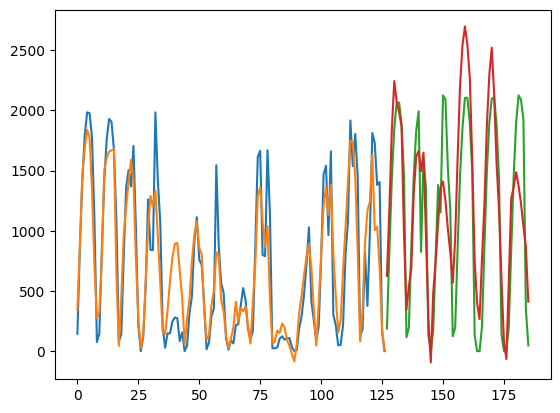

In [18]:
plt.plot(np.arange(len(train_indices)), y_train.loc[train_indices])
plt.plot(np.arange(len(train_indices)), mdl.predict(X_train.loc[train_indices]), label='train_data')
plt.plot(np.arange(len(train_indices), len(train_indices) + len(test_indices)), y_test.loc[test_indices], label='test data')
plt.plot(np.arange(len(train_indices), len(train_indices) + len(test_indices)), mdl.predict(X_test.loc[test_indices]))
#plt.vlines(x=[150], ymin=-10, ymax=3000)

# Feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

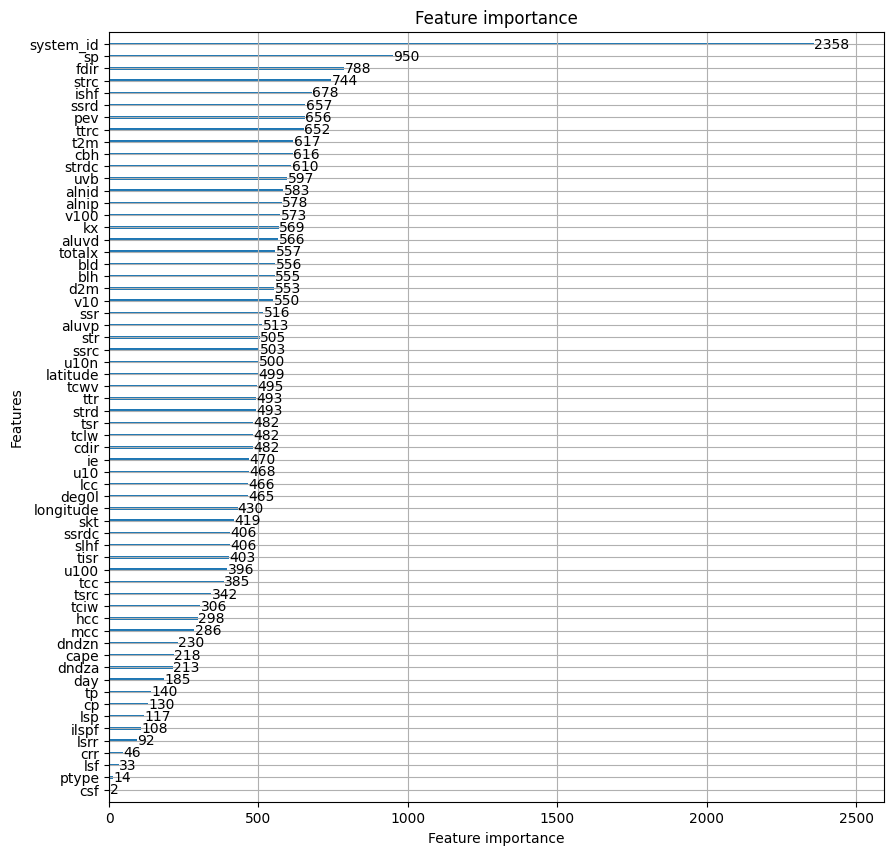

In [19]:
from lightgbm import plot_importance, plot_tree, plot_split_value_histogram
plot_importance(mdl, figsize=(10,10))

SP - surface - pressure seems to be an important feature in this model, even more so that FDIR (total surface radiation) and STRC (clear sky radiation).

In [20]:
mdl.fit(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1), y_train)

c:\Users\Mihir\anaconda3\envs\watai\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
c:\Users\Mihir\anaconda3\envs\watai\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMRegressor(categorical_feature=[0, 33], colsample_bynode=0.65,
              colsample_bytree=0.5, learning_rate=0.04, max_depth=10,
              min_child_weight=0, min_split_gain=0.0001, n_estimators=1000,
              num_leaves=30, subsample=1, subsample_freq=1)

In [21]:
pred = mdl.predict(X_test.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1))

In [22]:
wmape(y_test, pred)

34.160790444886246

In [23]:
mean_absolute_error(y_test, pred)

560.399954718209

In [24]:
wmape(y_train, mdl.predict(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1)))

17.98447211666172

In [25]:
mean_absolute_error(y_train, mdl.predict(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1)))

225.4300718600493

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

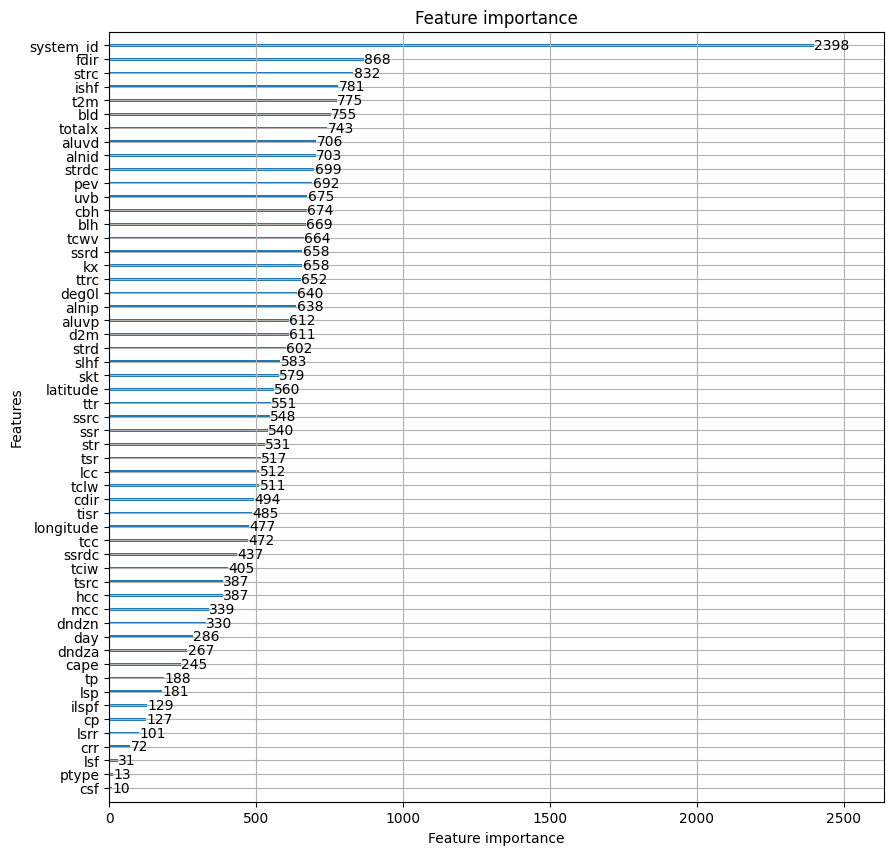

In [26]:
from lightgbm import plot_importance, plot_tree, plot_split_value_histogram
plot_importance(mdl, figsize=(10,10))

# Optuna HPT

In [27]:
X_train, X_test = X[X['day'] < 15], X[X['day'] >= 15]
y_train = df[df['day'] < 15]['instantaneous_power_W']
y_test = df[df['day'] >= 15]['instantaneous_power_W']

In [28]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression_l1',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'n_estimators': trial.suggest_int('num_iterations', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

    mdl = lgb.train(param, dtrain)

    return wmape(y_test, mdl.predict(X_test))

# 3. Create a study object and optimize the objective function.
dtrain = lgb.Dataset(X_train, y_train)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-08-13 21:41:21,147] A new study created in memory with name: no-name-e2fdddb9-e9c0-48dc-b305-6b4bcc0adab0
[I 2023-08-13 21:41:25,010] Trial 0 finished with value: 35.652239848131785 and parameters: {'lambda_l1': 3.700316193023526e-06, 'lambda_l2': 0.0005260514250817237, 'num_leaves': 79, 'num_iterations': 322, 'feature_fraction': 0.7862479041207326, 'bagging_fraction': 0.5533423598611793, 'bagging_freq': 7, 'max_depth': 5, 'learning_rate': 0.05594458700741076}. Best is trial 0 with value: 35.652239848131785.
[I 2023-08-13 21:42:12,687] Trial 1 finished with value: 29.22096511394941 and parameters: {'lambda_l1': 5.832173876400562e-05, 'lambda_l2': 1.9570269558574043, 'num_leaves': 252, 'num_iterations': 849, 'feature_fraction': 0.8523490327941798, 'bagging_fraction': 0.9210429724271924, 'bagging_freq': 1, 'max_depth': 12, 'learning_rate': 0.03532675980905302}. Best is trial 1 with value: 29.22096511394941.
[I 2023-08-13 21:42:25,596] Trial 2 finished with value: 32.5044341866235

In [29]:
opt_params = study.best_trial.params

In [30]:
print(opt_params)

{'lambda_l1': 5.832173876400562e-05, 'lambda_l2': 1.9570269558574043, 'num_leaves': 252, 'num_iterations': 849, 'feature_fraction': 0.8523490327941798, 'bagging_fraction': 0.9210429724271924, 'bagging_freq': 1, 'max_depth': 12, 'learning_rate': 0.03532675980905302}


In [31]:
opt_mdl = LGBMRegressor(**opt_params)

In [32]:
opt_mdl.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8523490327941798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523490327941798
[LightGBM] [Warning] bagging_fraction is set=0.9210429724271924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210429724271924
[LightGBM] [Warning] lambda_l1 is set=5.832173876400562e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.832173876400562e-05
[LightGBM] [Warning] lambda_l2 is set=1.9570269558574043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9570269558574043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.9210429724271924, bagging_freq=1,
              feature_fraction=0.8523490327941798,
              lambda_l1=5.832173876400562e-05, lambda_l2=1.9570269558574043,
              learning_rate=0.03532675980905302, max_depth=12,
              num_iterations=849, num_leaves=252)

In [33]:
pred = opt_mdl.predict(X_test)

In [34]:
wmape(y_test, pred)

29.600278288890426

In [35]:
wmape(y_train, opt_mdl.predict(X_train))

5.292910685797351


TODO
1) Feature selection test
- look into RFE for pruning (recursive feature elimination in sklearn)
- we want to identify the subset of features that results in the best performing model (we will need 1+ years of data to do this, and will want to cross-validate using different sites and also different subsets of the features)
2) Feature engineering task
- we want to generate Fourier feature for each PV sites (we will force period to be 365.25 for one of them)
- similar to sinusoidal regression
- we want to generate some unique features to each site based on historical PV output and metadata (average daily output, theoretical maximum daily output)
- scrape features from metadata (shade, orientation, panel brand, number of panels,panel_capacity_W_each)
3) Optuna HPT
- experiment with different boosting types (gbdt, dart, rf), and different methods of regulating overfitting (lambda params, max depth param, etc... will need to research for this)
- we will also want to use cross validation and probably early-stopping to avoid overfitting
4) Error exploration
- look at distribution of MAE, WMAPE
- Are outliers caused by outliers in our targets or outliers in our predictions?
- Check for negative predictions
- Compare predicted vs true value - where is lgbm going "wrong"? Does it tend to underpredict? Overpredict? Does it predict 0 at the right times? Is it properly adapting to spikes in power generation?
5) Data Task
- get 2 years data uploaded to GCP

In [36]:
mae = np.abs(y_test-pred)
#mae = mae[mae < 2000]

In [37]:
mae.max()

34143.49041263282

In [38]:
mae.sum()/len(mae)

485.58579578253716

In [39]:
mae = mae[mae < 2000]

In [40]:
mae.sum()/len(mae)

301.247065604044

In [41]:
cmap = sns.diverging_palette(10, 500, as_cmap=True)

In [42]:
corr = df.drop(['time', 'instantaneous_power_W', 'system_id'], axis=1).corrwith(df['instantaneous_power_W'])
corr = pd.DataFrame(corr)

<AxesSubplot:>

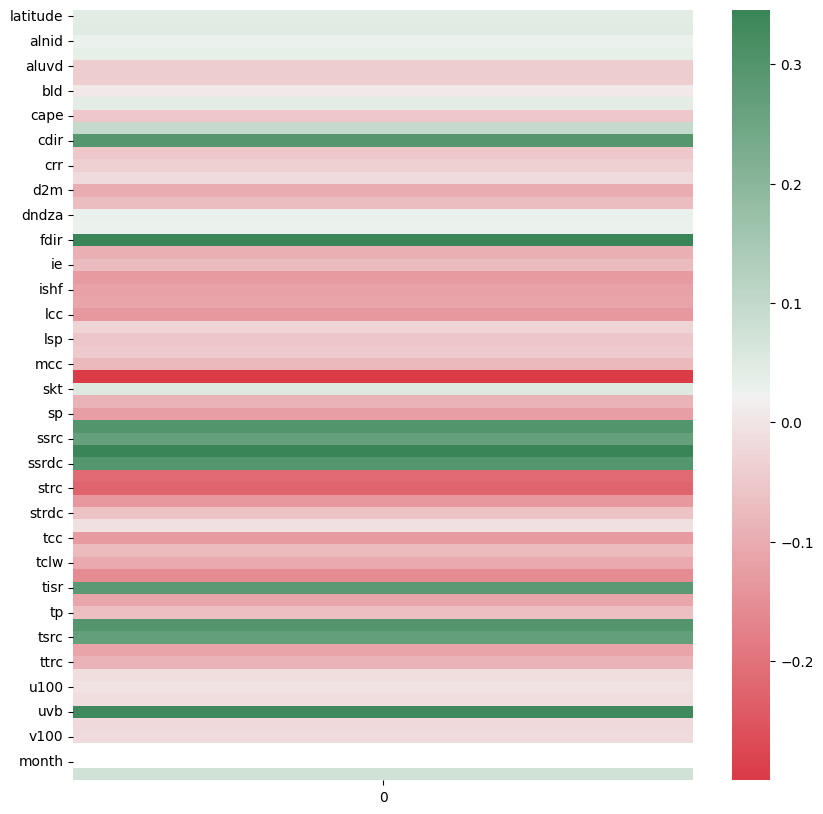

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap=cmap)

In [44]:
c = df.drop('time',axis=1).corr()

<AxesSubplot:>

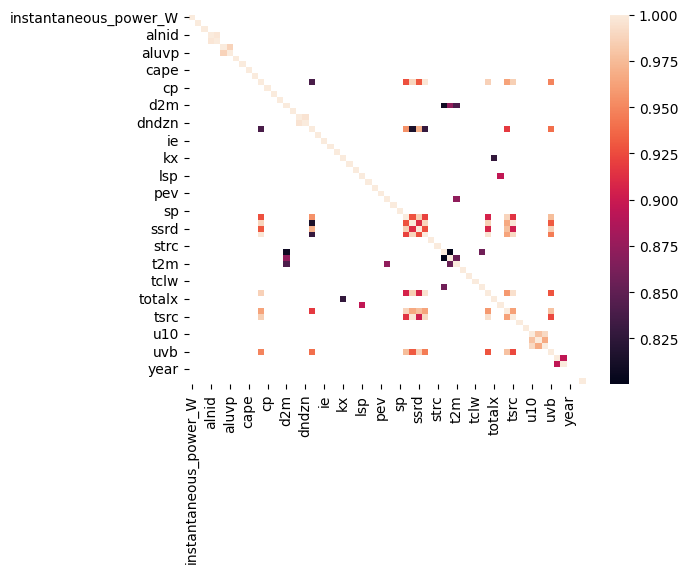

In [45]:
sns.heatmap(c[c>0.8])

### 3) Experiment with Optuna HPT

Try Optuna HPT with **dart**

In [48]:
def objective_dart(trial):

     param = {
        'objective': 'regression_l1',
        'verbosity': -1,
        'boosting_type': 'dart',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'n_estimators': trial.suggest_int('num_iterations', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }
     
     mdl = lgb.train(param, dtrain)

     return wmape(y_test, mdl.predict(X_test))

dtrain = lgb.Dataset(X_train, y_train)
study = optuna.create_study(direction='minimize')
study.optimize(objective_dart, n_trials=10)

[I 2023-08-13 21:54:34,409] A new study created in memory with name: no-name-8ba88be4-3700-41af-9714-1b7fe539c318


[I 2023-08-13 21:55:06,982] Trial 0 finished with value: 35.92410467434615 and parameters: {'lambda_l1': 0.00019467008557730688, 'lambda_l2': 8.677305964593572e-07, 'num_leaves': 74, 'num_iterations': 682, 'feature_fraction': 0.721690162430237, 'bagging_fraction': 0.9673574587383894, 'bagging_freq': 2, 'max_depth': 7, 'learning_rate': 0.0477839880899671}. Best is trial 0 with value: 35.92410467434615.
[I 2023-08-13 21:55:40,314] Trial 1 finished with value: 34.2467178670744 and parameters: {'lambda_l1': 0.0072274858826464295, 'lambda_l2': 1.2607857571476569e-06, 'num_leaves': 32, 'num_iterations': 872, 'feature_fraction': 0.699639560394212, 'bagging_fraction': 0.5919645705630764, 'bagging_freq': 5, 'max_depth': 8, 'learning_rate': 0.08100918069920394}. Best is trial 1 with value: 34.2467178670744.
[I 2023-08-13 21:56:28,369] Trial 2 finished with value: 40.440586177997254 and parameters: {'lambda_l1': 0.000808447180268365, 'lambda_l2': 5.618121122274925e-07, 'num_leaves': 124, 'num_ite

In [49]:
opt_params = study.best_trial.params
print(opt_params)
opt_mdl = LGBMRegressor(**opt_params)
opt_mdl.fit(X_train, y_train)
predict = opt_mdl.predict(X_test)
wmape(y_train, opt_mdl.predict(X_train))

{'lambda_l1': 8.327965403102382e-08, 'lambda_l2': 3.533901731576915e-05, 'num_leaves': 27, 'num_iterations': 662, 'feature_fraction': 0.8586745050958946, 'bagging_fraction': 0.9514438508024577, 'bagging_freq': 6, 'max_depth': 6, 'learning_rate': 0.09571858291885316}
[LightGBM] [Warning] feature_fraction is set=0.8586745050958946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586745050958946
[LightGBM] [Warning] bagging_fraction is set=0.9514438508024577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9514438508024577
[LightGBM] [Warning] lambda_l1 is set=8.327965403102382e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.327965403102382e-08
[LightGBM] [Warning] lambda_l2 is set=3.533901731576915e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.533901731576915e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


14.802184912562907

Try Optuna HPT with **rf**

In [52]:
def objective_rf(trial):

     param = {
        'objective': 'regression_l1',
        'verbosity': -1,
        'boosting_type': 'rf',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'n_estimators': trial.suggest_int('num_iterations', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }
     
     mdl = lgb.train(param, dtrain)

     return wmape(y_test, mdl.predict(X_test))

dtrain = lgb.Dataset(X_train, y_train)
study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=10)

[I 2023-08-13 22:09:31,174] A new study created in memory with name: no-name-1db24082-76fe-47ab-a0c4-75b950aed21b


[I 2023-08-13 22:09:45,448] Trial 0 finished with value: 63.99214160492281 and parameters: {'lambda_l1': 0.00013447242158761232, 'lambda_l2': 2.8891038242323173e-07, 'num_leaves': 160, 'num_iterations': 940, 'feature_fraction': 0.8064115263942954, 'bagging_fraction': 0.9156253101545386, 'bagging_freq': 2, 'max_depth': 5, 'learning_rate': 0.07866288595300824}. Best is trial 0 with value: 63.99214160492281.
[I 2023-08-13 22:09:51,760] Trial 1 finished with value: 64.0420991747306 and parameters: {'lambda_l1': 7.553181785138065e-05, 'lambda_l2': 1.4224145442643484e-06, 'num_leaves': 179, 'num_iterations': 195, 'feature_fraction': 0.5288414221464611, 'bagging_fraction': 0.5368317452898828, 'bagging_freq': 3, 'max_depth': 14, 'learning_rate': 0.08021154933777108}. Best is trial 0 with value: 63.99214160492281.
[I 2023-08-13 22:10:32,949] Trial 2 finished with value: 62.36196709648044 and parameters: {'lambda_l1': 1.550593216097432e-05, 'lambda_l2': 1.0124155272981343, 'num_leaves': 254, 'nu

In [53]:
opt_params = study.best_trial.params
print(opt_params)
opt_mdl = LGBMRegressor(**opt_params)
opt_mdl.fit(X_train, y_train)
predict = opt_mdl.predict(X_test)
wmape(y_train, opt_mdl.predict(X_train))


{'lambda_l1': 1.550593216097432e-05, 'lambda_l2': 1.0124155272981343, 'num_leaves': 254, 'num_iterations': 886, 'feature_fraction': 0.8646752939603823, 'bagging_fraction': 0.9424288650327902, 'bagging_freq': 4, 'max_depth': 15, 'learning_rate': 0.01793348850449457}
[LightGBM] [Warning] feature_fraction is set=0.8646752939603823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8646752939603823
[LightGBM] [Warning] bagging_fraction is set=0.9424288650327902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424288650327902
[LightGBM] [Warning] lambda_l1 is set=1.550593216097432e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.550593216097432e-05
[LightGBM] [Warning] lambda_l2 is set=1.0124155272981343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0124155272981343
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


7.630687453092799